# QCSubmit Protein Fragments TorsionDrive preparation

In [2]:
import os

from qcsubmit.factories import TorsiondriveDatasetFactory
from openforcefield.topology import Molecule
from openforcefield.utils.toolkits import RDKitToolkitWrapper, UndefinedStereochemistryError

We'll use the same artifacts produced for submitting Optimizations in "2020-08-12-OpenFF-Protein-Fragments-version2".

Need to:
- [ ] generate dihedral atoms for each molecule that we want to torsiondrive
- [ ] prepare README
- [ ] prepare `dataset.json`

In [3]:
factory = TorsiondriveDatasetFactory()

In [4]:
factory.scf_properties

['dipole', 'quadrupole', 'wiberg_lowdin_indices', 'mayer_indices']

In [5]:
dataset = factory.create_dataset(dataset_name="OpenFF Protein Fragments TorsionDrives v1.0",
                                 tagline="Torsiondrives for selected dihedrals of various protein fragments",
                                 description="Torsiondrives for selected dihedrals of various protein fragments",
                                 molecules=[])

In [6]:
dataset.metadata.submitter = 'dotsdl'

In [7]:
dataset.dict()

{'qc_specifications': {'default': {'method': 'B3LYP-D3BJ',
   'basis': 'DZVP',
   'program': 'psi4',
   'spec_name': 'default',
   'spec_description': 'Standard OpenFF optimization quantum chemistry specification.',
   'store_wavefunction': 'none'}},
 'dataset_name': 'OpenFF Protein Fragments TorsionDrives v1.0',
 'dataset_tagline': 'Torsiondrives for selected dihedrals of various protein fragments',
 'dataset_type': 'TorsiondriveDataset',
 'maxiter': 200,
 'driver': <DriverEnum.gradient: 'gradient'>,
 'scf_properties': ['dipole',
  'quadrupole',
  'wiberg_lowdin_indices',
  'mayer_indices'],
 'priority': 'normal',
 'description': 'Torsiondrives for selected dihedrals of various protein fragments',
 'dataset_tags': ['openff'],
 'compute_tag': 'openff',
 'metadata': {'submitter': 'dotsdl',
  'creation_date': datetime.date(2020, 10, 6),
  'collection_type': 'TorsiondriveDataset',
  'dataset_name': 'OpenFF Protein Fragments TorsionDrives v1.0',
  'short_description': 'Torsiondrives for se

We need to add molecules next, along with dihedrals selected for torsion driving.

We have molecules, initial geometries, and connectivity from the original optimization dataset.
We'll need to find a way to generate reasonable dihedrals we want to drive.
This is not something I have an immediate path in mind for.

## Prototyping from a single molecule

In [7]:
def build_molecule(folder, n_conformers=None):
    """
    Create a molecule from all of the conformers in the folder.
    """
    molecules = []
    for file in os.listdir(folder):
        if file.endswith(".mol2") and not file.startswith('.'):
            # this is one of the molecules
            try:
                mol2 = Molecule.from_file(os.path.join(folder, file))
            except UndefinedStereochemistryError:
                # if we get undefined stereochemistry, we skip this conformer
                print(f"Undefined stereochemistry for {folder}/{file}; skipping")
                continue
            # now save again in PDB format
            name = file.split(".")[0]
            # fix issue with openeye reordering when writing files.
            mol2.to_file(os.path.join(folder, name + ".pdb"), "pdb", RDKitToolkitWrapper())
            # load up the new molecule
            pdb = Molecule.from_file(os.path.join(folder, name + ".pdb"))
            molecules.append(pdb)
            
    # now we need to condense all of the conformers down to one molecule.
    return_mol = molecules.pop()
    for molecule in molecules:
        if n_conformers is None:
            return_mol.add_conformer(molecule.conformers[0])
        else:
            # TODO: from Cerutti, need to know if he recommends a selection scheme here
            return_mol.add_conformer(molecule.conformers[0])
        
    return return_mol

In [8]:
def gather_constraints(folder):
    """
    Create a set of all of the dihedral constraints in the given folder.
    """
    first = True
    constraints = set()
    for i, file in enumerate(os.listdir(folder)):
        if file.endswith(".frz") and not file.startswith('.'):
            # this is a constraint file
            constraints_i = set()
            with open(os.path.join(folder, file)) as cons_data:
                for line in cons_data.readlines()[1:]:
                    constraint = [int(x)-1 for x in line.split()[:4]] # subtracting 1 from indices because they are 1-based, and we need 0-based
                    constraints_i.add(tuple(constraint))
            if not first:
                assert constraints_i == constraints
                
            constraints.update(constraints_i)
            first = False
                    
    return constraints

In [9]:
mol = build_molecule('Input_files/ASP/ALA_ASP_SER/')

We want to drive (every 15deg):
- phi and psi combinatorically (grid search)
- phi and chi1 combinatorically (grid search)
- psi and chi1 combinatorically (grid search)

Beyond this, we may want to try adding strain to other angles:
- N Ca Cb
- N Ca C
- basically all backbone angle perturbations

From conversation with the QCA group today, we can technically do 2D torsion scans, but using this data in ForceBalance is something we cannot currently do.
We decided we'd be better served at present by doing each torsion as its own torsion scan for our given conformers.

In [10]:
mol.n_conformers

39

In [11]:
mol.find_rotatable_bonds()

[Bond(atom1 index=8, atom2 index=14),
 Bond(atom1 index=20, atom2 index=23),
 Bond(atom1 index=18, atom2 index=20),
 Bond(atom1 index=6, atom2 index=8),
 Bond(atom1 index=4, atom2 index=6),
 Bond(atom1 index=14, atom2 index=16),
 Bond(atom1 index=28, atom2 index=30),
 Bond(atom1 index=30, atom2 index=32),
 Bond(atom1 index=37, atom2 index=39),
 Bond(atom1 index=8, atom2 index=10),
 Bond(atom1 index=1, atom2 index=4),
 Bond(atom1 index=18, atom2 index=26),
 Bond(atom1 index=26, atom2 index=28),
 Bond(atom1 index=30, atom2 index=37),
 Bond(atom1 index=32, atom2 index=35),
 Bond(atom1 index=16, atom2 index=18),
 Bond(atom1 index=39, atom2 index=41)]

In [12]:
# perhaps use this, filter out where one atom is a hydrogen, 
# central two atoms must define a bond in the above `find_rotatable_bonds` list
len(mol.propers)

100

This probably isn't the approach we want to take. Way too many. Need a programmatic approach to selecting only the dihedrals we want.

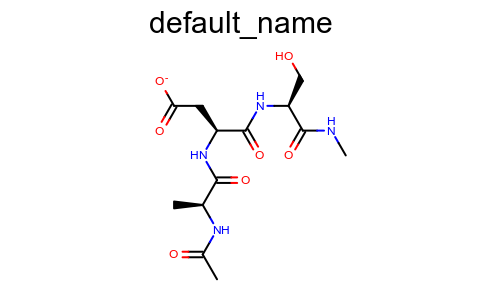

In [13]:
mol.visualize(backend='openeye')

In [14]:
omega_smarts = 'CC(=O)N[C:1][C:2](=O)[N:3][C:4]C(=O)NCC(=O)NC'
omega = mol.chemical_environment_matches(omega_smarts)
omega

[(8, 14, 16, 18)]

In [15]:
phi_smarts = 'CC(=O)NC[C:1](=O)[N:2][C:3][C:4](=O)NCC(=O)NC'
phi = mol.chemical_environment_matches(phi_smarts)
phi

[(14, 16, 18, 26)]

In [16]:
psi_smarts = 'CC(=O)NCC(=O)[N:1][C:2][C:3](=O)[N:4]CC(=O)NC'
psi = mol.chemical_environment_matches(psi_smarts)
psi

[(16, 18, 26, 28)]

In [17]:
chi1_smarts = 'CC(=O)NCC(=O)[N:1][C:2]([C:3][C:4])C(=O)NCC(=O)NC'
chi1 = mol.chemical_environment_matches(chi1_smarts)
chi1

[(16, 18, 20, 23)]

In [18]:
chi2_smarts = 'CC(=O)NCC(=O)N[C:1]([C:2][C:3][*:4])C(=O)NCC(=O)NC'
chi2 = mol.chemical_environment_matches(chi2_smarts)
chi2

[(18, 20, 23, 24)]

## Verify our selections work for all mols

In [19]:
mol = build_molecule('Input_files/ASP/ALA_ASP_SER/')

## Approaches

Pursuing two approaches, as separate submissions:

1. Medium priority. phi, psi, chi1 of central atom (if chi1 exists). Use strict SMARTS matching for selection of dihedral indices.

2. Low priority. All heavy torsions. We start with `mol.propers`, remove any that have H at 1 or 4 positions, remove any whose central bond not in `mol.rotatable_bonds`.

We have some options on where we get our `initial_molecules`. Should we get them:
1. **from the mol2/pdb files in the input_data.**
2. from the `dataset.json` used for the OptimizationDataset submission
3. from the public QCArchive itself

Choose 1 to give DC a pathway for submission.

We will want to use the dihedral freeze constraints used in the original optimization submission.
For each driven torsion, **remove** the constraint corresponding to that torsion.

We'll go up to chi2; not advised to go beyond.

Omega should be rotated +/- 20 degrees.

Let's start with three conformers for each molecule.
Still valuable to have more than one conformer per molecule.

### Approach 1

We will do the following:

1. Pull molecules with conformers from directories similarly to how Josh Horton did this.
2. For each molecule, for each of phi, psi, omega, chi1, chi2 selection, `dataset.add_molecule` for each one, using a distinct index for each submitted `TorsionDrive`.
    - be sure to extract the dihderal constraints (similar to Horton's code) and exclude the constraint on the dihedral we are driving

In [20]:
dihedrals = {'omega': omega_smarts,
             'phi': phi_smarts,
             'psi': psi_smarts,
             'chi1': chi1_smarts,
             'chi2': chi2_smarts}

In [21]:
factory = TorsiondriveDatasetFactory()

In [22]:
factory.scf_properties

['dipole', 'quadrupole', 'wiberg_lowdin_indices', 'mayer_indices']

In [23]:
# what's the difference between tagline and description?
dataset = factory.create_dataset(dataset_name="OpenFF Protein Fragments TorsionDrives v1.0",
                                 tagline="Torsiondrives for selected dihedrals of various protein fragments",
                                 description="Torsiondrives for selected dihedrals of various protein fragments",
                                 molecules=[])

In [24]:
dataset.metadata.submitter = 'dotsdl'

In [25]:
def populate_dataset(dataset, input_files):
    
    for folder in os.listdir(input_files):
        folder_path = os.path.join(input_files, folder)

        if not os.path.isdir(folder_path):
            print(folder)
            continue

        for combination in os.listdir(folder_path):
            combination_path = os.path.join(folder_path, combination)
            print("collecting from folder", combination_path)

            if ".tar" not in combination_path:
                constraints  = gather_constraints(combination_path)
                molecule = build_molecule(combination_path)

                attributes = factory.create_cmiles_metadata(molecule)

                for dihedral, dihedral_smarts in dihedrals.items():
                    index = "-".join([combination.lower(), dihedral])
                    
                    dihedral_indices = mol.chemical_environment_matches(dihedral_smarts)
                    
                    # drop constraint on dihedral we are rotating
#                     geometric_constraints = []
#                     for constraint in constraints:
#                         if constraint == dihedral_indices:
#                             continue
#                         geometric_constraints.append({"type": "dihedral", "indices": list(constraint)})
                    #keywords = {"constraints": {"freeze": geometric_constraints}}

                    dataset.add_molecule(index=index, 
                                         molecule=molecule, 
                                         dihedrals=dihedral_indices,
                                         attributes=attributes)
                                         #keywords=keywords)
    return dataset

Oh no...are the constraints 1-based? They seem off by 1 from our indices in our example above. This would impact the optimization dataset as well... :/

Definitely 1-based from inspection of a mol2 file against its corresponding constraints file. We'll need to shift all constraint indices down by 1 to apply to our molecule atoms. Adjusted our `gather_constraints` function above.

Can also check dihedrals using QCSubmit with generated PDF (be sure to generate the PDF!).
`dataset.visualize(filename)`

Might be of interest to toss in an ANI compute spec; Josh is interested in running an ANI compute spec locally to see if convergence problems arise quickly.

In [26]:
ds = populate_dataset(dataset, 'Input_files/')

collecting from folder Input_files/GLN/VAL_GLN_GLY
collecting from folder Input_files/GLN/ALA_GLN_GLY
collecting from folder Input_files/GLN/GLY_GLN_SER
collecting from folder Input_files/GLN/SER_GLN_VAL
collecting from folder Input_files/GLN/GLY_GLN_ALA
collecting from folder Input_files/GLN/ALA_GLN_VAL
collecting from folder Input_files/GLN/GLY_GLN_GLY
collecting from folder Input_files/GLN/ConfGLN.tar.gz
collecting from folder Input_files/GLN/SER_GLN_SER
collecting from folder Input_files/GLN/ALA_GLN_SER
collecting from folder Input_files/GLN/SER_GLN_GLY
collecting from folder Input_files/GLN/SER_GLN_ALA
collecting from folder Input_files/GLN/VAL_GLN_VAL
collecting from folder Input_files/GLN/ALA_GLN_ALA
collecting from folder Input_files/GLN/GLY_GLN_VAL
collecting from folder Input_files/GLN/VAL_GLN_SER
Undefined stereochemistry for Input_files/GLN/VAL_GLN_SER/Conf524.mol2; skipping
collecting from folder Input_files/GLN/VAL_GLN_ALA
collecting from folder Input_files/GLH/ALA_GLH_SE

/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C14H28N7O5 has a net charge of 1.0.
  UserWarning,


collecting from folder Input_files/ARG/GLY_ARG_GLY


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C13H26N7O4 has a net charge of 1.0.
  UserWarning,


collecting from folder Input_files/ARG/SER_ARG_ALA


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C15H30N7O5 has a net charge of 1.0.
  UserWarning,


collecting from folder Input_files/ARG/ALA_ARG_ALA


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C15H30N7O4 has a net charge of 1.0.
  UserWarning,


collecting from folder Input_files/ARG/VAL_ARG_VAL


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C19H38N7O4 has a net charge of 1.0.
  UserWarning,


collecting from folder Input_files/ARG/SER_ARG_SER


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C15H30N7O6 has a net charge of 1.0.
  UserWarning,


collecting from folder Input_files/ARG/GLY_ARG_VAL


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C16H32N7O4 has a net charge of 1.0.
  UserWarning,


collecting from folder Input_files/ARG/ALA_ARG_GLY


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C14H28N7O4 has a net charge of 1.0.
  UserWarning,


collecting from folder Input_files/ARG/SER_ARG_VAL
Undefined stereochemistry for Input_files/ARG/SER_ARG_VAL/Conf508.mol2; skipping


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C17H34N7O5 has a net charge of 1.0.
  UserWarning,


collecting from folder Input_files/ARG/GLY_ARG_ALA
collecting from folder Input_files/ARG/ConfARG.tar.gz
collecting from folder Input_files/ARG/SER_ARG_GLY
collecting from folder Input_files/ARG/ALA_ARG_SER
Undefined stereochemistry for Input_files/ARG/ALA_ARG_SER/Conf515.mol2; skipping
collecting from folder Input_files/ARG/ALA_ARG_VAL


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C17H34N7O4 has a net charge of 1.0.
  UserWarning,


collecting from folder Input_files/ARG/VAL_ARG_ALA
collecting from folder Input_files/ARG/VAL_ARG_SER
collecting from folder Input_files/ARG/VAL_ARG_GLY
collecting from folder Input_files/GLU/GLY_GLU_GLY


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C12H19N4O6 has a net charge of -1.0.
  UserWarning,


collecting from folder Input_files/GLU/GLY_GLU_ALA


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C13H21N4O6 has a net charge of -1.0.
  UserWarning,


collecting from folder Input_files/GLU/VAL_GLU_GLY


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C15H25N4O6 has a net charge of -1.0.
  UserWarning,


collecting from folder Input_files/GLU/VAL_GLU_ALA
Undefined stereochemistry for Input_files/GLU/VAL_GLU_ALA/Conf467.mol2; skipping


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C16H27N4O6 has a net charge of -1.0.
  UserWarning,


collecting from folder Input_files/GLU/GLY_GLU_VAL
Undefined stereochemistry for Input_files/GLU/GLY_GLU_VAL/Conf517.mol2; skipping
collecting from folder Input_files/GLU/ALA_GLU_ALA


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C14H23N4O6 has a net charge of -1.0.
  UserWarning,


collecting from folder Input_files/GLU/VAL_GLU_VAL
Undefined stereochemistry for Input_files/GLU/VAL_GLU_VAL/Conf488.mol2; skipping


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C18H31N4O6 has a net charge of -1.0.
  UserWarning,


collecting from folder Input_files/GLU/ALA_GLU_VAL
collecting from folder Input_files/GLU/ConfGLU.tar.gz
collecting from folder Input_files/GLU/ALA_GLU_GLY
collecting from folder Input_files/ASP/ConfASP.tar.gz
collecting from folder Input_files/ASP/SER_ASP_VAL


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C15H25N4O7 has a net charge of -1.0.
  UserWarning,


collecting from folder Input_files/ASP/VAL_ASP_VAL


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C17H29N4O6 has a net charge of -1.0.
  UserWarning,


collecting from folder Input_files/ASP/ALA_ASP_VAL
collecting from folder Input_files/ASP/VAL_ASP_ALA
collecting from folder Input_files/ASP/ALA_ASP_ALA
collecting from folder Input_files/ASP/GLY_ASP_VAL
collecting from folder Input_files/ASP/ALA_ASP_GLY
collecting from folder Input_files/ASP/SER_ASP_ALA


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C13H21N4O7 has a net charge of -1.0.
  UserWarning,


collecting from folder Input_files/ASP/GLY_ASP_ALA
collecting from folder Input_files/ASP/GLY_ASP_GLY


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C11H17N4O6 has a net charge of -1.0.
  UserWarning,


collecting from folder Input_files/ASP/SER_ASP_SER


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C13H21N4O8 has a net charge of -1.0.
  UserWarning,


collecting from folder Input_files/ASP/VAL_ASP_GLY
collecting from folder Input_files/ASP/GLY_ASP_SER


/home/david/.conda/envs/qcsubmit/lib/python3.7/site-packages/qcsubmit/validators.py:181: UserWarning: The molecule C12H19N4O7 has a net charge of -1.0.
  UserWarning,


collecting from folder Input_files/ASP/SER_ASP_GLY
collecting from folder Input_files/ASP/VAL_ASP_SER
collecting from folder Input_files/ASP/ALA_ASP_SER
collecting from folder Input_files/GLY/VAL_GLY_ALA
collecting from folder Input_files/GLY/ConfGLY.tar.gz
collecting from folder Input_files/GLY/SER_GLY_ALA
collecting from folder Input_files/GLY/VAL_GLY_VAL
collecting from folder Input_files/GLY/SER_GLY_VAL
collecting from folder Input_files/GLY/VAL_GLY_SER
collecting from folder Input_files/GLY/GLY_GLY_VAL
collecting from folder Input_files/GLY/SER_GLY_SER
collecting from folder Input_files/GLY/ALA_GLY_GLY
collecting from folder Input_files/GLY/GLY_GLY_ALA
collecting from folder Input_files/GLY/ALA_GLY_ALA
collecting from folder Input_files/GLY/ALA_GLY_VAL
collecting from folder Input_files/GLY/SER_GLY_GLY
collecting from folder Input_files/GLY/VAL_GLY_GLY
collecting from folder Input_files/GLY/ALA_GLY_SER
collecting from folder Input_files/GLY/GLY_GLY_SER
collecting from folder Input

In [30]:
ds.export_dataset('dataset.json')

In [31]:
ds.visualize('torsions.pdf')

Need to reduce conformers; consult with Cerutti tomorrow on selection basis (could we take first n conformers for each tripeptide?)

In [32]:
ds.n_records

925

In [33]:
ds.n_molecules

185

In [ ]:
ds.n_molecules

In [34]:
ds.add_molecule?

Signature:
ds.add_molecule(
    index: str,
    molecule: openforcefield.topology.molecule.Molecule,
    attributes: Dict[str, Any],
    extras: Union[Dict[str, Any], NoneType] = None,
    keywords: Union[Dict[str, Any], NoneType] = None,
    **kwargs,
) -> None
Docstring:
Add a molecule to the dataset under the given index with the passed cmiles.

Parameters:
index : str
    The molecule index that was generated by the factory.
molecule : openforcefield.topology.Molecule
    The instance of the molecule which contains its conformer information.
attributes : Dict[str, str]
    The attributes dictionary containing all of the relevant identifier tags for the molecule and
    extra meta information on the calculation.
extras : Dict[str, Any], optional, default=None
    The extras that should be supplied into the qcportal.moldels.Molecule.
keywords : Dict[str, Any], optional, default=None,
    Any extra keywords which are required for the calculation.

Note:
    Each molecule in this basic